In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np

def createPerfPlot(csv_file_path: str, title: str):
    # Lists to store data
    x_values = []
    y_values_lists = []

    # Read data from CSV file
    with open(csv_file_path, 'r') as file:
        reader = csv.reader(file)
        header = next(reader)  # Read the header to get column names

        x_column_index = header.index('M')  # Replace 'x_column_name' with the actual column name for x-axis
        y_column_indices = []
        for i in range(1, len(header)):
            y_column_indices.append(i)  # Replace with actual column names for y-axis

        for i in range(len(y_column_indices)):
            y_values_lists.append([])

        for row in reader:
            # Extract x-axis values
            x_values.append(float(row[x_column_index]))

            # Extract y-axis values
            for y_index in y_column_indices:
                y_values_lists[y_index - 1].append(float(row[y_index]))        

    # Plot the data
    # x_values = [f'{xx}' for xx in np.arange(100)]
    for i, y_values in enumerate(y_values_lists):
        plt.plot(x_values, y_values, label=header[i + 1])

    # Adding labels and title
    plt.xlabel('TFLOPS')
    plt.ylabel('Square Matrix Dimension')
    plt.title(title)

    # Adding legend
    plt.legend()

    # Display the plot
    plt.show()
    

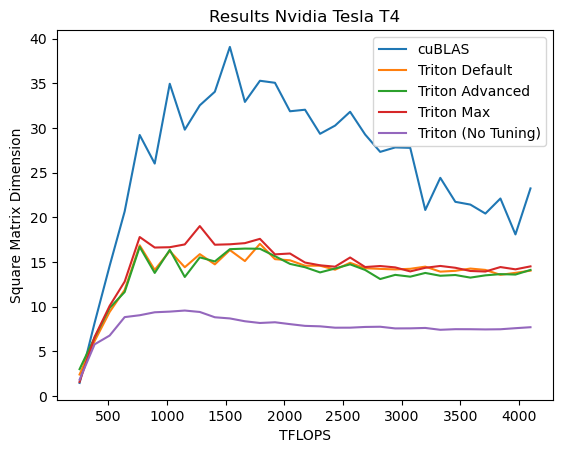

In [3]:


# Specify the path to your CSV file
csv_file_path = 'Triton/matmul/T4/pure/restults_tesla_t4.csv'
title = 'Results Nvidia Tesla T4'

createPerfPlot(csv_file_path=csv_file_path, title=title)




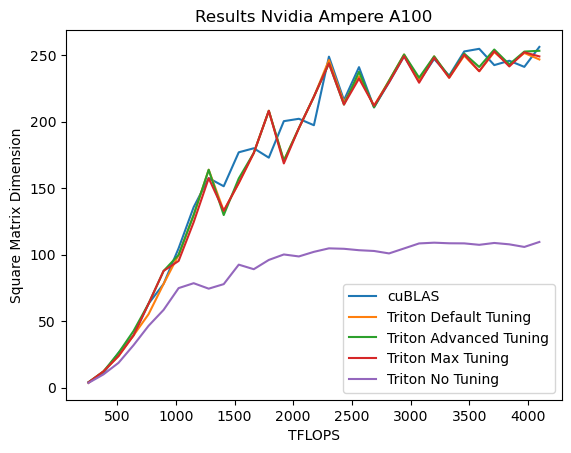

In [2]:
# Specify the path to your CSV file
csv_file_path = 'Triton/matmul/A100/results_ampere_A100.csv'
title = 'Results Nvidia Ampere A100'

createPerfPlot(csv_file_path=csv_file_path, title=title)